### Find accuracy of using xgboost on the loan data

In [24]:
import numpy as np
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib


### Load the data

In [25]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

### Split the training data into training and validation data

In [26]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.1,
    stratify=y_train,
    random_state=42
)

### Build the xgboost model

In [27]:
xgb_model = XGBClassifier(
    use_label_encoder=False,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    eval_metric='aucpr',
    random_state=42
)

In [28]:
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

[0]	validation_0-aucpr:0.99092
[1]	validation_0-aucpr:0.99319
[2]	validation_0-aucpr:0.99296
[3]	validation_0-aucpr:0.99730
[4]	validation_0-aucpr:0.99724
[5]	validation_0-aucpr:0.99734
[6]	validation_0-aucpr:0.99711
[7]	validation_0-aucpr:0.99758
[8]	validation_0-aucpr:0.99777
[9]	validation_0-aucpr:0.99781
[10]	validation_0-aucpr:0.99797
[11]	validation_0-aucpr:0.99785
[12]	validation_0-aucpr:0.99790
[13]	validation_0-aucpr:0.99787
[14]	validation_0-aucpr:0.99787
[15]	validation_0-aucpr:0.99798
[16]	validation_0-aucpr:0.99792
[17]	validation_0-aucpr:0.99789
[18]	validation_0-aucpr:0.99800
[19]	validation_0-aucpr:0.99794
[20]	validation_0-aucpr:0.99794
[21]	validation_0-aucpr:0.99799
[22]	validation_0-aucpr:0.99796
[23]	validation_0-aucpr:0.99784
[24]	validation_0-aucpr:0.99772
[25]	validation_0-aucpr:0.99786
[26]	validation_0-aucpr:0.99791
[27]	validation_0-aucpr:0.99790
[28]	validation_0-aucpr:0.99792
[29]	validation_0-aucpr:0.99787
[30]	validation_0-aucpr:0.99792
[31]	validation_0-

/opt/anaconda3/envs/tf-mac/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [01:44:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[93]	validation_0-aucpr:0.99803
[94]	validation_0-aucpr:0.99803
[95]	validation_0-aucpr:0.99803
[96]	validation_0-aucpr:0.99803
[97]	validation_0-aucpr:0.99803
[98]	validation_0-aucpr:0.99803
[99]	validation_0-aucpr:0.99803


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

### Evaluate the model accuracy using test data

In [29]:

y_pred = xgb_model.predict(X_test)


              precision    recall  f1-score   support

           0      0.987     0.975     0.981       323
           1      0.985     0.992     0.989       531

    accuracy                          0.986       854
   macro avg      0.986     0.984     0.985       854
weighted avg      0.986     0.986     0.986       854



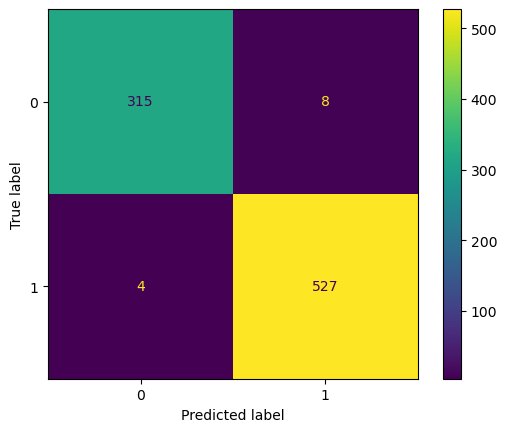

In [30]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

print(classification_report(y_test, y_pred, digits=3))

In [31]:
print("Model accuracy:", xgb_model.score(X_test, y_test))

Model accuracy: 0.9859484777517564


### Comparing Logistics Regression to XGboost, XGboost has the higher accuracy

In [32]:
joblib.dump(xgb_model, 'loan_xgb_model.pkl') # Save the model for future use

['loan_xgb_model.pkl']

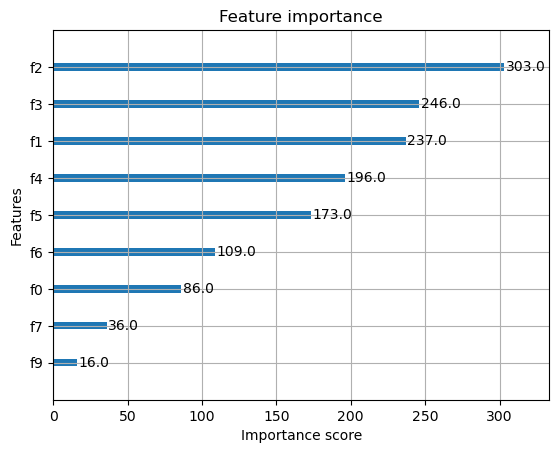

In [33]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xgb_model)
plt.show()

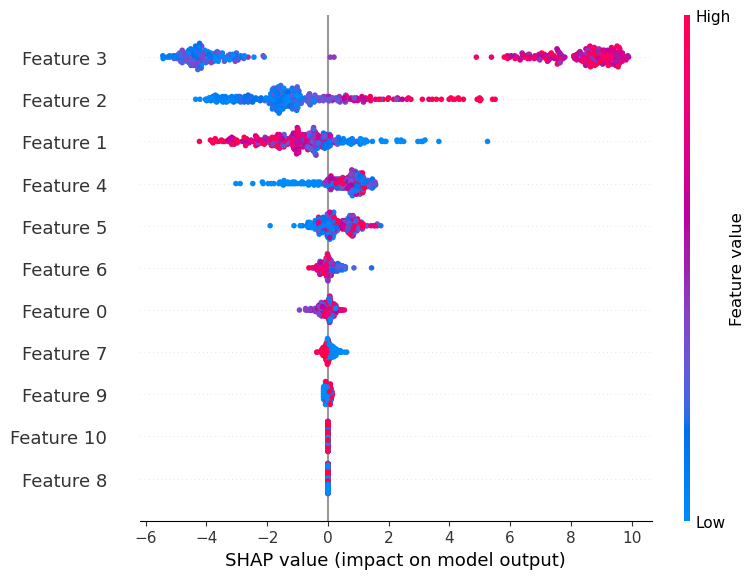

In [34]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val)